In [ ]:
# import sys
# !{sys.executable} -m pip install -r requirements.txt

In [1]:
import pandas as pd

In [9]:
df = pd.read_csv("./output/Samsum/Control/microsoft_Phi-4-mini-instruct_Samsum.csv")
df[244:245]

,Model,Task_Prefix,Dataset_Name,Model_Responses,Gold_Labels,Min_K_Responses,cos_sim_scores,rouge_sim_scores,levenshtein_distance
244,microsoft/Phi-4-mini-instruct,Summarize the following text:,Samsum,# Problem:What is the value of $left(1 - frac{...,"{'Min_10.0% Prob': 10.8828125, 'Min_20.0% Prob...",0.03773733600974083,"{'rouge1': Score(precision=0.1, recall=0.09090...",NaN,130


In [1]:
from nltk import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import pipeline
import random
random.seed(99) # setting seed
classifier = pipeline("fill-mask")

In [4]:
# Download the parquet data from Huggingface
samsum = load_dataset("Samsung/samsum", revision="refs/convert/parquet", data_files={"test": "samsum/test/0000.parquet"})["test"]
webis = load_dataset("webis/tldr-17", revision="refs/convert/parquet", data_files={"default": "default/partial-train/000*.parquet"})["default"]

In [5]:
# Take a random 10% of Webis
webis_sel = webis.shuffle(seed=42).train_test_split(test_size=0.01)
webis_test = webis_sel['test']

In [24]:
w_test = webis_test.to_pandas()
s_test = samsum.to_pandas()

## Generate "unseen" data

Verifying contamination in other studies typically include comparison of model performance on suspect vs. validation datasets. To generate validation datasets, we can use Huggingface Fill-mask!

TODO: do we have to generate accompanying alternate/validation summaries? or do we just track the similarity of model responses to the alternate/validation contents TO the original gold summaries? 

Supposing if we change some `n` tokens in the original content, we can track the cosine similarity btween the original and perturbated content. Will we see an "opposing" trend with the perturbated content and the gold summaries (more similar than expected)?

In [25]:
# aux columns for token counting
s_test["dialogue_length"] = s_test.dialogue.apply(word_tokenize).apply(len)
s_test["summary_length"] = s_test.summary.apply(word_tokenize).apply(len)
w_test["summary_length"] = w_test.summary.apply(word_tokenize).apply(len)
w_test["content_length"] = w_test.content.apply(word_tokenize).apply(len)

In [29]:
# filter data by sequence length
w_short = w_test.loc[w_test.content_length < 512, :]
s_short = s_test.loc[s_test.dialogue_length < 512, :]

In [20]:
# set number of tokens to be masked/generated
n = 1

# for each instance in a test split, mask N tokens and generate an alternate
def generate_mask(example, n=1):
    tokens = example.split(" ")
    mask = random.sample(list(range(len(tokens))), n)

    result = []
    for i in range(len(tokens)):
        if i in mask:
            result.append("<mask>")
        else:
            result.append(tokens[i])
    return " ".join(result)

def generate_validation(masked_example):
    return classifier(masked_example)

In [30]:
w_short["mask_example"] = w_short.content.apply(lambda e: generate_mask(e, n))
s_short["mask_example"] = s_short.dialogue.apply(lambda e: generate_mask(e, n))

/var/folders/st/p2js96993zq5v79qwdjfx64m0000gn/T/ipykernel_80117/2973496849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_short["mask_example"] = w_short.content.apply(lambda e: generate_mask(e, n))
/var/folders/st/p2js96993zq5v79qwdjfx64m0000gn/T/ipykernel_80117/2973496849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_short["mask_example"] = s_short.dialogue.apply(lambda e: generate_mask(e, n))


In [32]:
w_short.mask_example

0        Now I'm not sure exactly what mulletdude is sa...
1        The real solution is to stop being a pussy. It...
2        Basically the thing I keep in mind is; Persona...
3        It was a good movie, overall, I think. Great a...
4        I am not sure exactly how many hours i put in ...
                               ...                        
13264    Sugru is very over priced. It's just silicone ...
13265    First of all, this is Chudat we're talking abo...
13266    Around 12 years ago I noticed over the course ...
13267    Hey longtime skateboarder & skate photographer...
13269    well, but in music you cant say that quality m...
Name: mask_example, Length: 12056, dtype: object

In [33]:
w_short["validation"] = w_short.mask_example.apply(generate_validation)
s_short["validation"] = s_short.mask_example.apply(generate_validation)

2025-03-04 00:54:14.727890: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: indices[0,512] = 514 is not in [0, 514)


InvalidArgumentError: Exception encountered when calling layer 'embeddings' (type TFRobertaEmbeddings).

{{function_node __wrapped__ResourceGather_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[0,512] = 514 is not in [0, 514) [Op:ResourceGather] name: 

Call arguments received by layer 'embeddings' (type TFRobertaEmbeddings):
  • input_ids=tf.Tensor(shape=(1, 566), dtype=int32)
  • position_ids=None
  • token_type_ids=tf.Tensor(shape=(1, 566), dtype=int32)
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False

## (Experimental) Cosine similarity filtering

Webis data can have very...colorful summaries sourced from TLDR comments. Linguistically, these do not serve the same purpose as the summaries in SAM-Sum. 

To mitigate this difference between the two datasets, we can drop rows where the provided summary has lower cosine similarity scores than any SAM-Sum instance. 

In [5]:
# Try taking cosine similarity on the provided summaries and original content/dialogue
def samsum_cos_sim(example):
    a = example['dialogue']
    b = example['summary']
    ax = embedder.encode(np.array([a]), convert_to_tensor=True)
    bx = embedder.encode(np.array([b]), convert_to_tensor=True)
    return {'cos_sim': get_cos_similarity_score(ax, bx)}

def webis_cos_sim(example):
    a = example['content']
    b = example['summary']
    ax = embedder.encode(np.array([a]), convert_to_tensor=True)
    bx = embedder.encode(np.array([b]), convert_to_tensor=True)
    return {'cos_sim': get_cos_similarity_score(ax, bx)}

### Cherry-picking
Let's see if my hypothesis about cosine similarity relating to summary relevance is correct:

In [66]:
x = w_test.loc[w_test.cos_sim < s_test.cos_sim.min()]
y = x.loc[x.content_length < 30]
z = y.sample(1)

In [67]:
z.iloc[0, 6]

'Wait wait wait. An optional drill mount? Does this mean I could technically outfit it with a door gun? Possibly on both sides.'

In [68]:
z.iloc[0, 7]

'NANITE SYSTEMS PLZ'

In [86]:
a = w_test.loc[w_test.cos_sim > s_test.cos_sim.mean()]
b = a.loc[a.content_length < 30]
c = b.sample(1)

In [87]:
c.iloc[0, 6]

'Its a clever and sneaky move by ms to try and lock people into their service eco system and get people off Google crack.'

In [88]:
c.iloc[0, 7]

'Microsoft is offering their crack on the same street corner as Google.'

### Comparing ranges

We can also check out the range of cosine similarity scores for both datasets

In [9]:
w_test.cos_sim.max()

0.9711474180221558

In [10]:
s_test.cos_sim.max()

0.9129816293716431

In [11]:
len(s_test.loc[s_test.cos_sim < 0.5]) / len(s_test)

0.03785103785103785

In [12]:
len(w_test.loc[w_test.cos_sim < 0.5]) / len(w_test)

0.6180859080633007

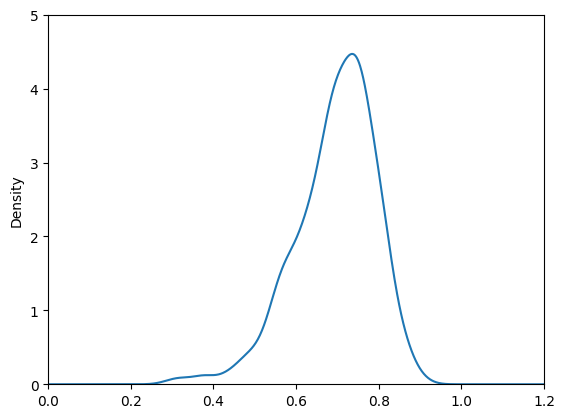

In [36]:
# Peek at cosine similarity density
s_test.cos_sim.plot(kind="kde")
plt.xlim(0, 1.2)
plt.ylim(0, 5)
plt.show()

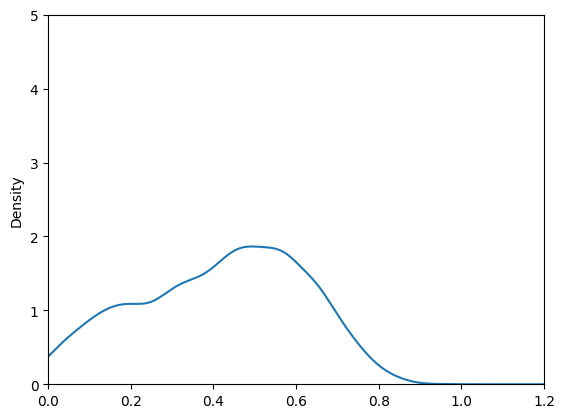

In [37]:
w_test.cos_sim.plot(kind="kde")
plt.xlim(0, 1.2)
plt.ylim(0, 5)
plt.show()

### Mitigating differences

Maybe we can filter Webis data to get a similar distribution of cosine similarity scores...

In [20]:
# Take a sample of Webis of similar volume to SAM-Sum
q = w_test.loc[w_test.cos_sim > s_test.cos_sim.min()].sample(n=819, random_state=42)

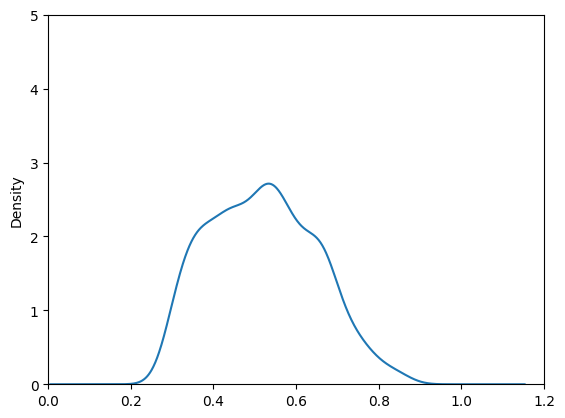

In [38]:
q.cos_sim.plot(kind="kde")
plt.xlim(0, 1.2)
plt.ylim(0, 5)
plt.show()

In [18]:
samsum_tokens = s_test.dialogue_length.sum() + s_test.summary_length.sum()
print("SAM-Sum: {} tokens".format(samsum_tokens))

SAM-Sum: 122662 tokens


In [21]:
webis_tokens = q.summary_length.sum() + q.content_length.sum()
print("Webis: {} tokens".format(webis_tokens))

Webis: 222504 tokens


## Generate D3 Data

Run the following cells to generate data. 

**If not using cosine-similarity filtering, replace `q` with `w_test`**

In [6]:
def generate_prompt(example):
    return "Summarize the following text:\n{}".format(example)

In [7]:
# Prepare final columns
w_test["prompt"] = w_test.content.apply(generate_prompt)
s_test["prompt"] = s_test.dialogue.apply(generate_prompt)
w_test["source"] = "webis"
s_test["source"] = "samsum"

In [35]:
# Generate results in a fresh DF
result = pd.DataFrame(columns=['id', 'prompt', 'source'])
result = pd.concat([result, s_test[['id', 'prompt', 'source']]])
result = pd.concat([result, q[['id', 'prompt', 'source']]])
result.reset_index(inplace=True, drop=True)
result

,id,prompt,source
0,13862856,"Summarize the following content:\nHannah: Hey,...",samsum
1,13729565,Summarize the following content:\nEric: MACHIN...,samsum
2,13680171,"Summarize the following content:\nLenny: Babe,...",samsum
3,13729438,Summarize the following content:\nWill: hey ba...,samsum
4,13828600,"Summarize the following content:\nOllie: Hi , ...",samsum
...,...,...,...
1633,chc2rzj,Summarize the following content:\nIf you're lo...,webis
1634,c6jiwdl,Summarize the following content:\nKayle is a v...,webis
1635,c3mtu8p,Summarize the following content:\nIf she delet...,webis
1636,cijaylo,Summarize the following content:\nIts a combin...,webis


In [34]:
result.to_csv("d3_data.csv", index=False)